# SC/BEP Data Insights

In [1]:
import pathlib
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore")

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.

### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
  

## Load datasets

In [3]:
country = gpd.read_file(pathlib.Path("data/country.geojson").open().read())

In [4]:
travels = pd.read_excel('data/travels.xlsx')

In [5]:
travels.columns

Index(['travel_id', 'mission_id', 'from_geocodeid', 'from_citycleansed',
       'from_ISO2', 'from_city', 'from_lat', 'from_lon', 'from_accuracy',
       'from_confidence', 'to_geocodeid', 'to_citycleansed', 'to_ISO2',
       'to_city', 'to_lat', 'to_lon', 'to_accuracy', 'to_confidence', 'start',
       'stop', 'travel_type', 'acronym', 'faculty', 'elapsed', 'distance'],
      dtype='object')

### Aggregate Travels to Missions

In [7]:
missions = travels.groupby('mission_id').agg({
    'acronym': 'first', 'faculty': 'first',
    'start': 'first', 'stop':'first', 'elapsed': 'first', 'travel_type': 'first',
    'from_ISO2': 'first', 'to_ISO2': list, 'distance': 'sum',
}).reset_index()
missions['speed'] = missions['distance']/(24*missions['elapsed'])
missions['travel_type'] = missions['travel_type'].fillna('unknown')
missions['to_ISO2-1'] = missions['to_ISO2'].apply(lambda x: x[0])
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,to_ISO2-1
0,0,DECA,LTC,2010-05-28,2010-06-01,5,unknown,BE,"[GB, GB, BE]",810.745964,6.756216,GB
1,1,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB
2,2,SIC,LTC,2010-06-22,2010-07-08,17,unknown,BE,"[GB, BE]",645.698894,1.582595,GB
3,3,SIC,LTC,2010-07-12,2010-07-17,6,unknown,BE,"[GB, BE]",645.698894,4.484020,GB
4,4,SIC,LTC,2010-05-31,2010-06-01,2,unknown,BE,"[FR, BE]",528.587028,11.012230,FR
...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,"[GB, BE]",645.698894,26.904121,GB
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,"[FR, FR, FR, BE]",1923.612609,13.358421,FR
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,"[FR, BE]",1536.399657,21.338884,FR
6128,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,"[FR, NL]",860.923418,17.935905,FR


In [8]:
missions[['elapsed', 'distance', 'speed']].describe()

,elapsed,distance,speed
count,6130.000000,6130.000000,6130.000000
mean,12.222023,3845.546147,30.104054
std,64.624680,5862.854903,64.016400
min,1.000000,0.000000,0.000000
25%,2.000000,528.587028,7.341487
50%,4.000000,1274.210955,14.304465
75%,7.000000,3430.315109,27.326370
max,2565.000000,51560.794898,1388.485110


In [9]:
missions = missions.loc[missions['elapsed']<31,:]
missions = missions.loc[missions['speed']<900,:]

In [10]:
missions[['elapsed', 'distance', 'speed']].describe()

,elapsed,distance,speed
count,5811.000000,5811.000000,5811.000000
mean,5.332301,3657.964976,31.077635
std,5.059497,5681.608808,61.851859
min,1.000000,0.000000,0.000000
25%,2.000000,528.587028,7.906664
50%,4.000000,1204.759456,14.962521
75%,7.000000,3164.852448,28.938322
max,30.000000,39186.535851,879.629618


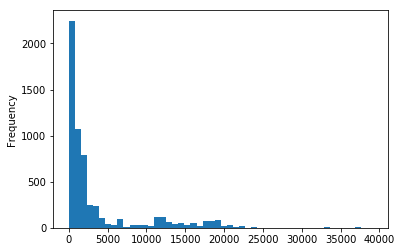

In [11]:
missions['distance'].plot(kind='hist', bins=50)

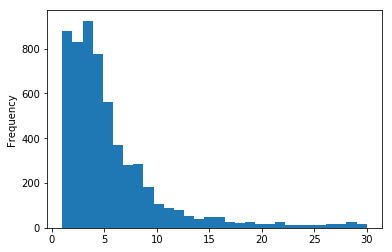

In [12]:
missions['elapsed'].plot(kind='hist', bins=30)

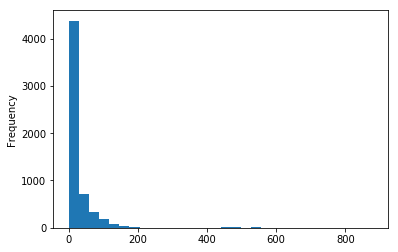

In [13]:
missions['speed'].plot(kind='hist', bins=30)

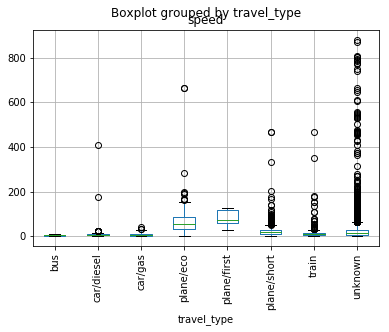

In [14]:
axe = missions.boxplot(column='speed', by='travel_type', rot=90)

(0, 200)

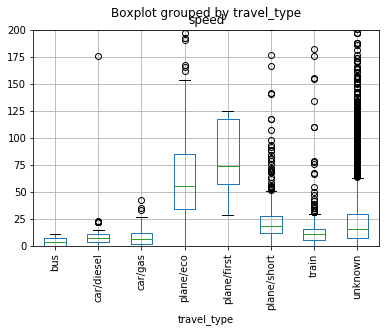

In [15]:
axe = missions.boxplot(column='speed', by='travel_type', rot=90)
axe.set_ylim([0 ,200])

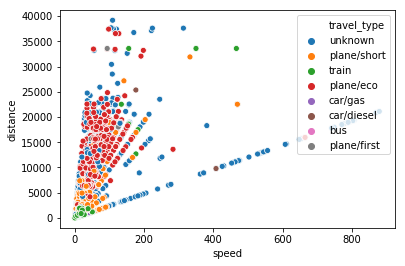

In [16]:
sns.scatterplot(x='speed', y='distance', hue='travel_type', data=missions)

In [17]:
y = missions['start'].dt.year

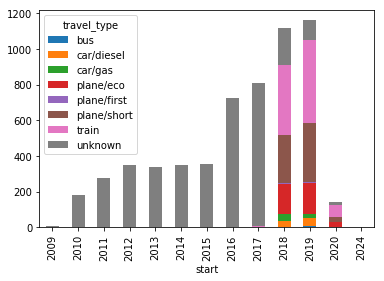

In [18]:
mc = missions.groupby([y, 'travel_type'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)

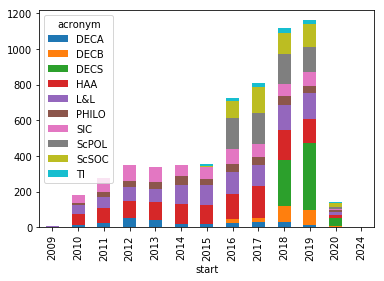

In [19]:
mc = missions.groupby([y, 'acronym'])['mission_id'].count().unstack()
axe = mc.plot(kind='bar', stacked=True)

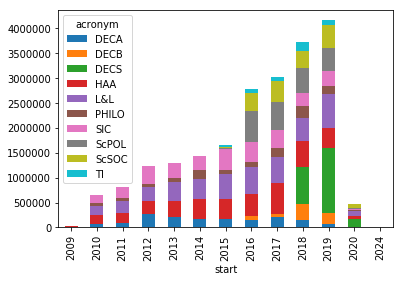

In [20]:
mc = missions.groupby([y, 'acronym'])['distance'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)

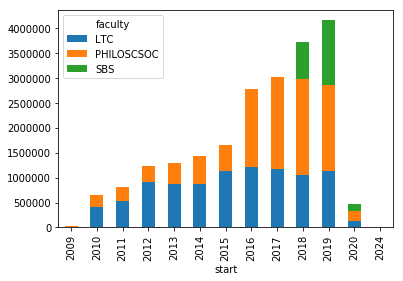

In [21]:
mc = missions.groupby([y, 'faculty'])['distance'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)

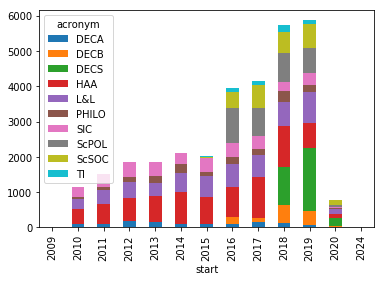

In [22]:
mc = missions.groupby([y, 'acronym'])['elapsed'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)

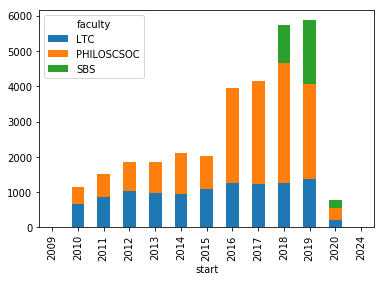

In [23]:
mc = missions.groupby([y, 'faculty'])['elapsed'].sum().unstack()
axe = mc.plot(kind='bar', stacked=True)

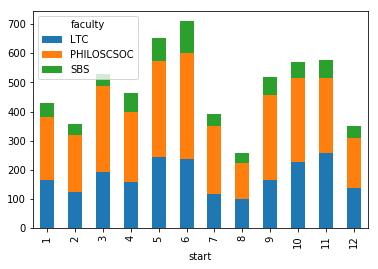

In [24]:
m = missions['start'].dt.month
missions.groupby([m, 'faculty'])['mission_id'].count().unstack().plot(kind='bar', stacked=True)

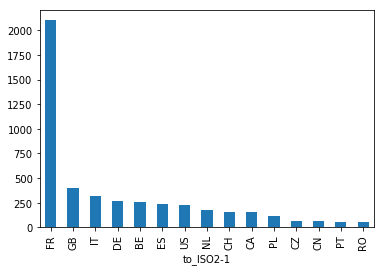

In [25]:
topc = missions.groupby("to_ISO2-1")["mission_id"].count().sort_values(ascending=False)
axe = topc[:15].plot(kind='bar')

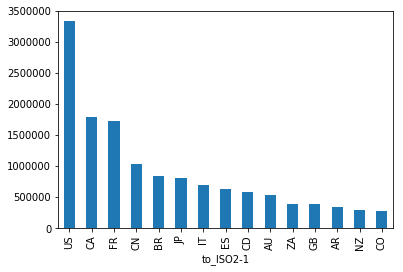

In [26]:
topd = missions.groupby("to_ISO2-1")["distance"].sum().sort_values(ascending=False)
axe = topd[:15].plot(kind='bar')

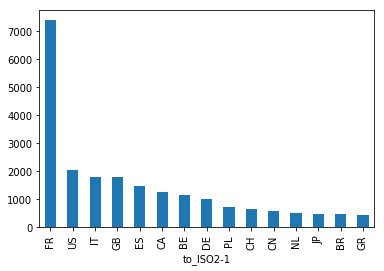

In [27]:
topt = missions.groupby("to_ISO2-1")["elapsed"].sum().sort_values(ascending=False)
axe = topt[:15].plot(kind='bar')

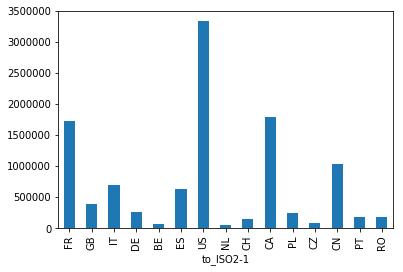

In [28]:
axe = topd[topc.index[:15]].plot(kind='bar')

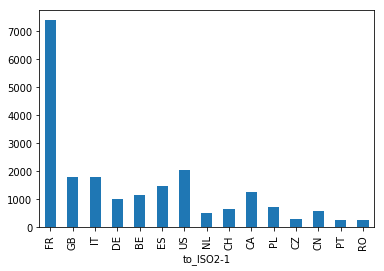

In [29]:
axe = topt[topc.index[:15]].plot(kind='bar')